# Bayesian Data Analysis Project: U.S. Births
### DTU, 2018
### Team Members: Inon Peled, Niklas Christopher Petersen, Mads Paulsen. 

# Introduction
TODO: The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order. The notebook presents a clear cohesive data analysis story, which is enjoyable to read. Structure and organization. What is the data and the analysis problem.

The model can be something already used in the course or something else, but don’t try to do
too complex things. Ther are separate project courses work for more complex models. So mention similarity to some homework models.

### Imports and Commonly Used Symbols

In [103]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import pystan
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [113]:
rcParams['figure.figsize'] = 16, 6
COMMON_SEED = 1234

def check_convergence(fit, also_print=False):
    report = print if also_print else lambda x: None
    
    def all_rhat_small_enough(fit):
        return all(dict(fit.summary())['summary'][:, -1] < 1.1)
    
    def max_treedepth_exceeded(fit, max_depth = 10):
        """Check transitions that ended prematurely due to maximum tree depth limit"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        depths = [x for y in sampler_params for x in y['treedepth__']]
        n = sum(1 for x in depths if x == max_depth)
        if n > 0:
            report('Run again with max_depth set to a larger value to avoid saturation')        
        N = len(depths)
        report(('{} of {} iterations saturated the maximum tree depth of {}'
               + ' ({}%)').format(n, N, max_depth, 100 * n / N))
        return float(n) / N
    
    def e_bfmi_all_low_enough(fit):
        """
        Checks the energy Bayesian fraction of missing information (E-BFMI).
        E-BFMI below 0.2 indicates you may need to reparameterize your model
        """
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        for chain_num, s in enumerate(sampler_params):
            energies = s['energy__']
            numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
            denom = np.var(energies)
            if numer / denom < 0.2:
                report('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
                report('E-BFMI below 0.2 indicates you may need to reparameterize your model')
                return False
        return True

    def fraction_of_transitions_which_ended_with_divergence(fit):
        """Check transitions that ended with a divergence"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        divergent = [x for y in sampler_params for x in y['divergent__']]
        n = sum(divergent)
        N = len(divergent)
        report('{} of {} iterations ended with a divergence ({}%)'
              .format(n, N, 100 * n / N))
        if n > 0:
            report('Try running with larger adapt_delta to remove the divergences')
        return n / N
    
    assert all_rhat_small_enough(fit)
    assert max_treedepth_exceeded(fit) < 0.02
    assert e_bfmi_all_low_enough(fit)
    assert fraction_of_transitions_which_ended_with_divergence(fit) == 0
    report("##### All convergence checks passed successfully. #####")

# Data Description

Before fitting prediction models, let us look into the data we have.

In [3]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


We assert that no data imputation is needed.

In [4]:
def num_days_in_year(year):
    return (datetime(year, 12, 31) - datetime(year, 1, 1)).days + 1


def missing_days(df):
    return births_2000s_df_with_index.groupby('year').births.describe()\
        .assign(expected_days=lambda df: list(map(num_days_in_year, df.index)))\
        .assign(missing=lambda df: df.expected_days - df['count'])

        
assert not any(missing_days(births_2000s_df_with_index).missing)

### Distribution Statistics

We next show how births distribute in each year, month, and day of week. We see that whereas the data follows a somewhat steady mean and std. dev. over years and over months, there are is much more variability between days of week:
1. There are numerous outliers in each day of week.
2. There are significantly _less_ births during the weekend (Saturday-Sunday) than during the work week (Monday-Friday).
3. Weekend days have lower variance than work days.

In [5]:
# def show_mean_and_std_by_time_dimension(time_dimension):
#     births_2000s_df_with_index.groupby(time_dimension).births.describe()[['mean', 'std']].plot.bar(fontsize=14)

# list(map(show_mean_and_std_by_time_dimension, ['weekday_name', 'year', 'month']));

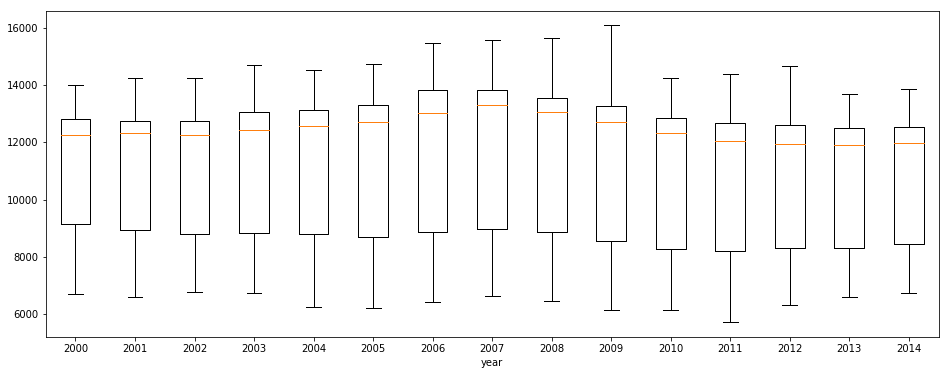

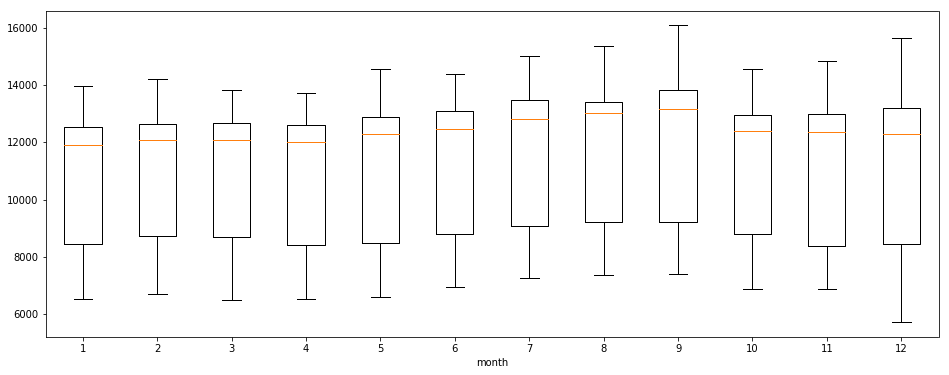

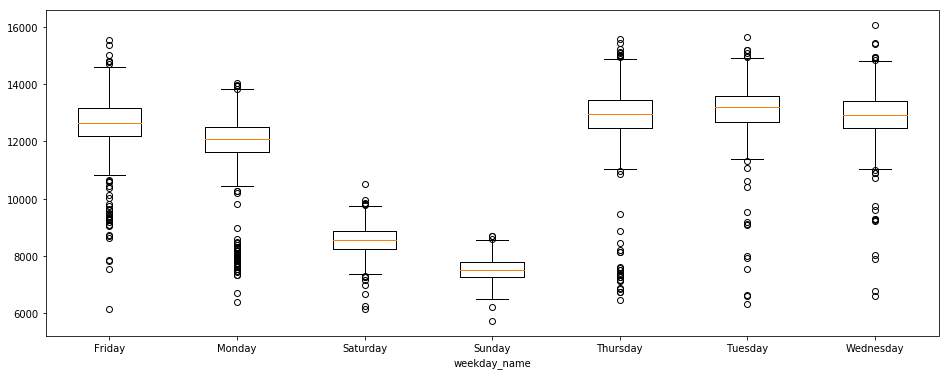

In [6]:
def boxplots(df, time_dimension):
    fig, ax = plt.subplots(1, 1)
    x = sorted(df[time_dimension].unique())
    ax.boxplot([list(df[df[time_dimension] == t].births) for t in x])
    ax.set_xticklabels(x)
    ax.set_xlabel(df[time_dimension].name)

    
for time_dimension in ('year', 'month', 'weekday_name'):
    boxplots(births_2000s_df_with_index, time_dimension)

We also take a look at the distribution of all data points, regardless of time. The distribution is markedly bimodal: one mode for weekend, the other for rest of week. In fact, the weekend distribution is bimodal too, because of differences between Saturday and Sunday.

/home/inonpe/jupyter/dtu_bda_project/env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


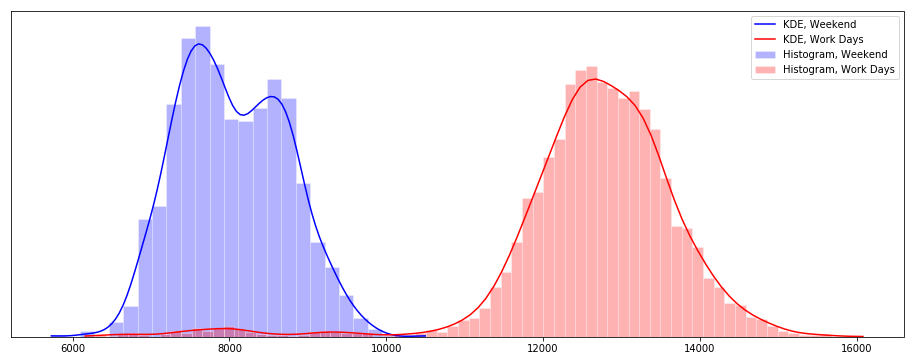

In [7]:
def density_estimation(df):
    fig, ax = plt.subplots(1, 1)
    births_weekend = df.births[df.day_of_week >= 6]
    births_work_days = df.births[df.day_of_week < 6]
    
    ax.hist(births_weekend, bins='auto', facecolor='blue', edgecolor='white', 
            normed=True, label="Histogram, Weekend", alpha=0.3)
    ax.hist(births_work_days, bins='auto', facecolor='red', edgecolor='white', 
            normed=True, label="Histogram, Work Days", alpha=0.3)

    x_kde_weekend = np.linspace(births_weekend.min(), births_weekend.max(), 100)
    ax.plot(x_kde_weekend, gaussian_kde(births_weekend)(x_kde_weekend),
            label="KDE, Weekend", color='blue')

    x_kde_work_days = np.linspace(births_work_days.min(), births_work_days.max(), 100)
    ax.plot(x_kde_work_days, gaussian_kde(births_work_days)(x_kde_work_days), label="KDE, Work Days", color='red')
    
    ax.get_yaxis().set_visible(False)
    ax.legend()
    
density_estimation(births_2000s_df_with_index)

Finally, we turn to look at Gaussian Kernel Density Estimation (KDE) for each weekday separately.

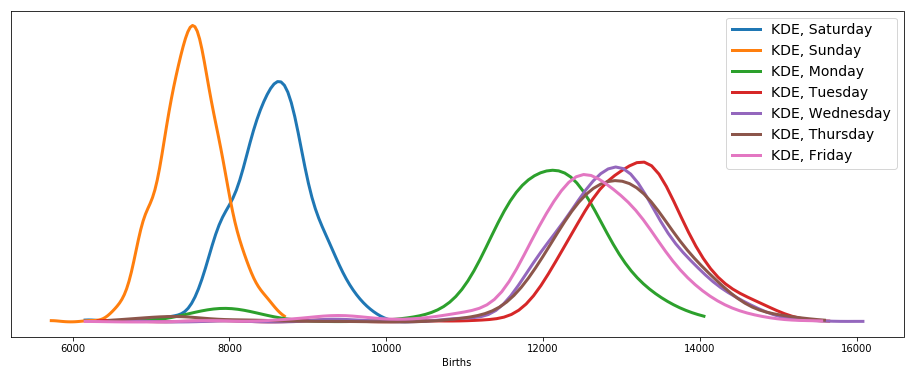

In [8]:
def density_estimation_by_weekday(df):
    fig, ax = plt.subplots(1, 1)
    for d in df.weekday_name.unique():
        daily_births = df.births[df.weekday_name == d]
        x_kde = np.linspace(daily_births.min(), daily_births.max(), 100)
        ax.plot(x_kde, gaussian_kde(daily_births)(x_kde), label="KDE, %s" % d, lw=3)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Births")
    ax.legend(fontsize=14)
    
density_estimation_by_weekday(births_2000s_df_with_index)

## Seasonality
The next few plots are meant to emphasize any obvious seasonality in the time series of births.

First, we see that each year displays are generally similar trend: steady increase in first few months, followed by a peak, a drop, and another peak at end of year.

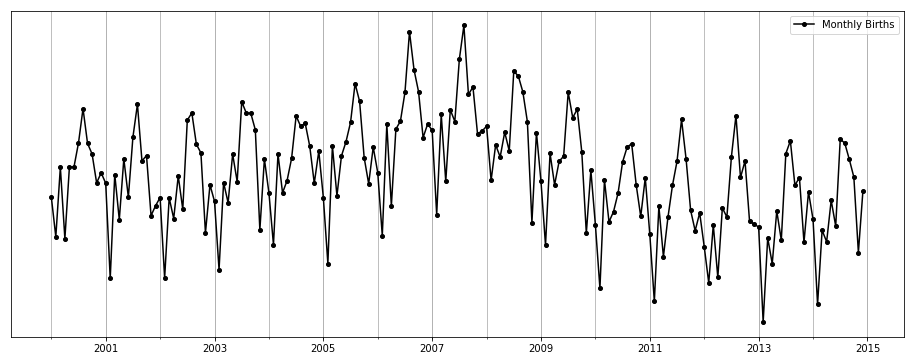

In [9]:
def plot_monthly_births(df):
    d = df.groupby(('year', 'month')).births.sum().reset_index()
    f = pd.to_datetime(d.assign(day=1).drop('births', axis=1))
    ax = d.set_index(f).drop(['year', 'month'], axis=1)\
        .births.rename("Monthly Births")\
        .plot(color="black", marker='o', markersize=4)
    ax.legend()
    ax.grid(which='both')
    ax.get_yaxis().set_visible(False)

plot_monthly_births(births_2000s_df_with_index)

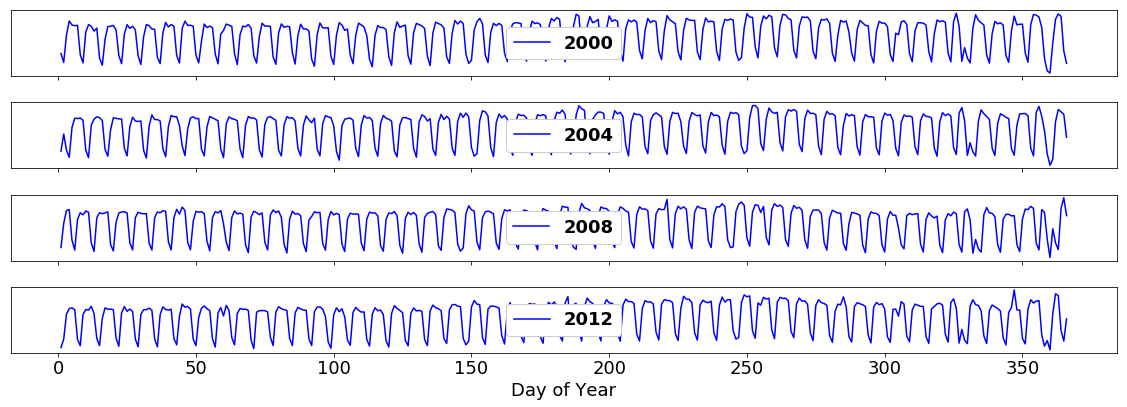

In [10]:
def compare_some_years(years):
    matplotlib.rc('font', **{'size': 18})
    fix, axes = plt.subplots(len(years), 1, sharex=True)
    for i, year in enumerate(years):
        axes[i].plot(
            births_2000s_df_with_index.set_index('day_of_year')[lambda r: r.year == year].births, 
            label=year, color='blue')
        axes[i].legend(prop={'weight':'bold'}, loc='center', framealpha=1)
        axes[i].get_yaxis().set_visible(False)
    axes[-1].set_xlabel("Day of Year")
    plt.tight_layout()
        
compare_some_years(range(2000, 2015, 4))

It is known that people are biased against giving births in some specific dates: holidays, 13th of each month, and 29th Feb. on leap years. However, in this work, we will not involve any contextual information, but rather use only the births data.

# Bayesian Inference Models and Priors

The following describes each Bayesian Inference model we test, along with justifications for choosing such a model, and a definition of the **prior distributions** which the model uses. All models work on standardized data, i.e. for each data point in a train set, we remove the train set mean and then divide by the train set std. dev.

### Models Disregarding the Time Series
The plot of KDEs shows that for each weekday, the data distribution resembles a Gaussian. We should thus try several models:
1. Searate Model: for each weekday $d=1..7$, assign parameters $\mu_d, \sigma_d>0$, each with prior $\mathcal{N}(0, 10)$, and let $y_n \sim \mathcal{N} \left( \mu_{x_n}, \sigma_{x_n}^2 \right)$, where $x_n$ is day-of-week.
2. Hierarchical Model: similar to Separate Model, except that all $\mu_d$ and all $\sigma_d$ are each drawn from a shared distribution.
3. Hierarchicial Model for work days, Separate Models for weekend days.

### Models Using the Time Series
1. For each day $t$, let
$$
x_t = \left( \text{year}_t, \text{month}_t, \text{day-of-month}_t, \text{day-of-week}_t \right)
$$
We model the number of births $y_t$ as following a prior Poisson distribution, with rate determined by data in days up to $t-1$, namely
$$
y_t \sim Poisson \left( exp\left(z_t\right) \right)
$$
where the exponent ensures that the Poisson rate is positive, and
$$
z_t \sim \mathcal{N}\left(\mu_t, \sigma_t^2\right)
$$
so that 
$$
\mu_t = \beta_\mu z_{t-1} + \theta_\mu^T x_t \\
\sigma_t = \beta_\sigma z_{t-1} + \theta_\sigma^T x_t
$$
The parameters to be learnt are $\beta_\mu, \beta_\sigma, \theta_mu, \theta_\sigma$, each with prior $\mathcal{N}(0, 10)$. In accordance with our data analysis, this model is heteroskedastic, i.e. allows a different variance $\sigma_t$ for each $t$.

2. Same as the former option, except that
$$
y_t \sim NB \left( r, \frac{exp(z_t)}{exp(z_t) + r} \right)
$$
Where NB is the Negative Binomial distribution, and $r$ is another parameter to be learnt. The Negative Binomial distribution allows for variance different than mean, and so is more robust than the Poisson distribution, where the mean and variance are the same.

TODO: Required onvergence diagnostic results (Rhat, neff, divergences) shown and maning of the results is discussed.
TODO: PGM drawings from e.g. ShinyStan?
TODO: A table summarizing the Stan parameters (chains, algorithm, etc.) we use in running each model.

# Models for Weekdays

## Baseline: Historical Average for Each Day Separately
For HA, there is no point in running a STAN model: our predictions will anyway be the hisotrical mean.

In [11]:
x = births_2000s_df_with_index.day_of_week.values
y = births_2000s_df_with_index.births.values
N = len(y)
print(x, y, N, sep='\n')

[6 7 1 ... 1 2 3]
[ 9083  8006 11363 ... 12811 13634 11990]
5479


In [12]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2000, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.day_of_week[:-7].values,
        'y_train': df.births[:-7].values,
        'x_test': df.day_of_week[-7:].values,
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': array([3, 4, 5, 6, 7, 1, 2]),
 'x_train': array([6, 7, 1, ..., 7, 1, 2]),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310]),
 'y_train': array([ 9083,  8006, 11363, ...,  7896, 13096, 12525])}

In [15]:
def historical_average(x_train, y_train):
    ha = np.empty(7)
    for i in range(7):
        ha[i] = y_train[x_train - 1 == i].mean()
    return ha

historical_average(x, y)

array([11897.83014049, 13122.44444444, 12910.76628352, 12845.82608696,
       12596.16240409,  8562.5734355 ,  7518.37675607])

0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 1000 iterations ended with a divergence (0.0%)
##### All convergence checks passed successfully. #####


In [45]:
def fit_ha_sliding_windows(num_windows):
    prediction_errors = []
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
#         print(data)
        y_pred = historical_average(data['x_train'], data['y_train'])[data['x_test'] - 1].round()
        prediction_errors.append(y_pred - data['y_test'])
#         print(y_pred)
#         print(data['y_test'])
    return np.concatenate(prediction_errors)

def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

rmse(fit_ha_sliding_windows(num_windows=51))

809.3249876126584

## Separate Model
In the separate model, each weekday $j$ is given an independent prior $\text{Cauchy}(\mu_j, \sigma_j)$, where $\mu_j$ equal to the sample mean and $\sigma_j$ equal to the sample standard deviation for weekday $j$. We choose the Cauchy distribution because it

In [107]:
model_separate_weekdays = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of predictions.
    int<lower=0> N; // Number of data points.
    vector[N] y_train; // Train data points.
    vector[T] y_test; // Test data points, for log-likelihood.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
}
parameters {
    real mu[7];    // Separate means.
    real<lower=0> sigma[7]; // Separate std. devs.
}
model {
    mu ~ normal(0, 10);
    sigma ~ cauchy(0, 5); // Half-Cauchy, because of non-negativity constraint.
    y_train ~ normal(mu[x_train], sigma[x_train]);
}
generated quantities {
    real loglik;
    vector[T] y_pred;
    loglik = 0;
    for (t in 1:T) {
        y_pred[t] = normal_rng(mu[x_test[t]], sigma[x_test[t]]);
        loglik += normal_lpdf(y_test[t] | mu[x_test[t]], sigma[x_test[t]]);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce322d14aa3ffe4f0201f5ab9f37d65c NOW.


In [109]:
data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=7))
fit = model_separate_weekdays.sampling(seed=COMMON_SEED, data=dict(
    x_train=data['x_train'],
    x_test=data['x_test'],
    y_train=data['y_train'],
    y_test=data['y_test'],
    T=7,
    N=len(data['x_train'])), iter=500)

In [110]:
check_convergence(fit)

In [111]:
fit

Inference for Stan model: anon_model_ce322d14aa3ffe4f0201f5ab9f37d65c.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]       6.07    0.33  10.36 -13.99  -1.13   6.11  13.03  27.07   1000    1.0
mu[1]       5.68    0.31   9.87 -13.62  -0.97   5.87  12.44  25.23   1000    1.0
mu[2]       5.54    0.31   9.83 -14.52  -0.78   5.62  11.99  25.22   1000    1.0
mu[3]       5.37    0.32  10.27 -14.52  -1.42   5.61  12.23   24.7   1000    1.0
mu[4]       5.43    0.33  10.43 -14.48  -1.86   5.51  12.65  26.13   1000    1.0
mu[5]       8.79    0.31   9.95 -11.54    2.4   8.82  15.36  28.81   1000    1.0
mu[6]        9.5    0.32  10.18  -10.7   2.96   9.34  16.29  28.81   1000    1.0
sigma[0]   1.2e4    9.78 309.39  1.1e4  1.2e4  1.2e4  1.2e4  1.3e4   1000    1.0
sigma[1]   1.3e4    11.4  360.4  1.2e4  1.3e4  1.3e4  1.3e4  1.4e4   1000    1.0
sigm

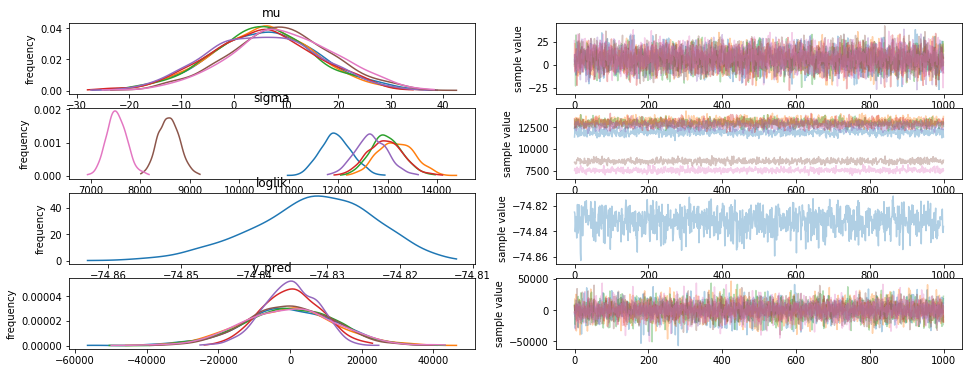

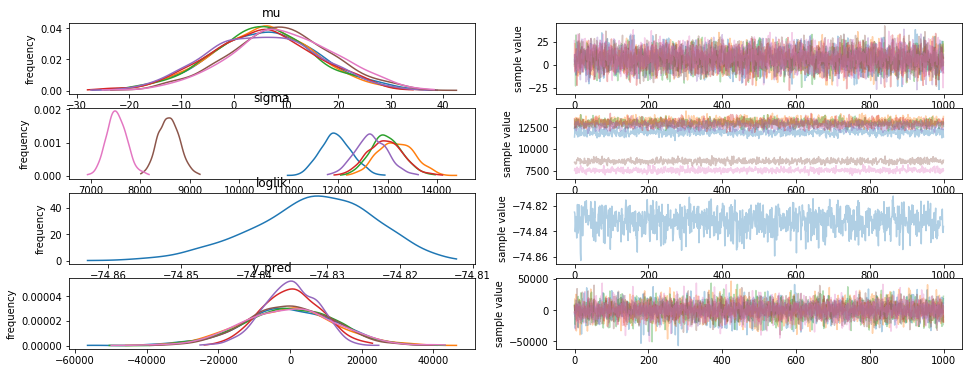

In [114]:
fit.plot()

## Stan Model: 2 Hierarchical Models, Poisson
We fit a distribution for each weekday, so that parameters for weekend days (Sat., Sun.) are derived from one distribution, and parameters for the other days (Mon.-Fri.) are derived from another distribution.

In [91]:
model_hier_poisson = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of days to predict ahead.
    int<lower=0> N; // Number of data points.
    int y[N]; // data points.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
}
parameters {
    real<lower=0> lambda[7];
    real<lower=0> lambda_weekend;
    real<lower=0> lambda_workdays;
    real<lower=0> sigma_weekend;
    real<lower=0> sigma_workdays;
}
model {
    sigma_weekend ~ cauchy(0, 10);
    sigma_workdays ~ cauchy(0, 10);
    lambda[6] ~ normal(lambda_weekend, sigma_weekend);
    lambda[7] ~ normal(lambda_weekend, sigma_weekend);
    for (i in 1:5) {
        lambda[i] ~ normal(lambda_workdays, sigma_workdays);
    }
    y ~ poisson(lambda[x_train]);
}
generated quantities {
    int y_pred[T];
    for (i in 1:T) {
        y_pred[x_test[i]] = poisson_rng(lambda[x_test[i]]);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a85692c7a37d733cc0bd1a22e1e3ea45 NOW.


In [92]:
data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=7))
fit = model_hier_poisson.sampling(seed=COMMON_SEED, data=dict(
    x_train=data['x_train'],
    x_test=data['x_test'],
    y=data['y_train'],
    T=7,
    N=len(data['x_train'])), iter=500)
# check_convergence(fit)

In [94]:
check_convergence(fit)

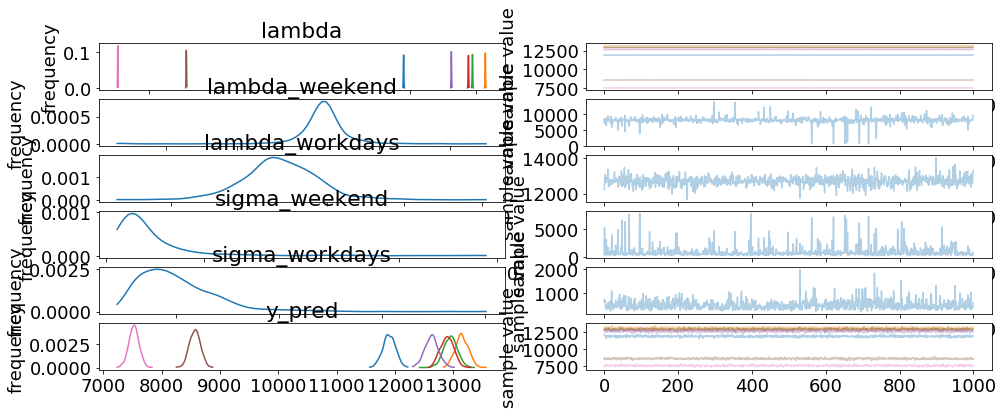

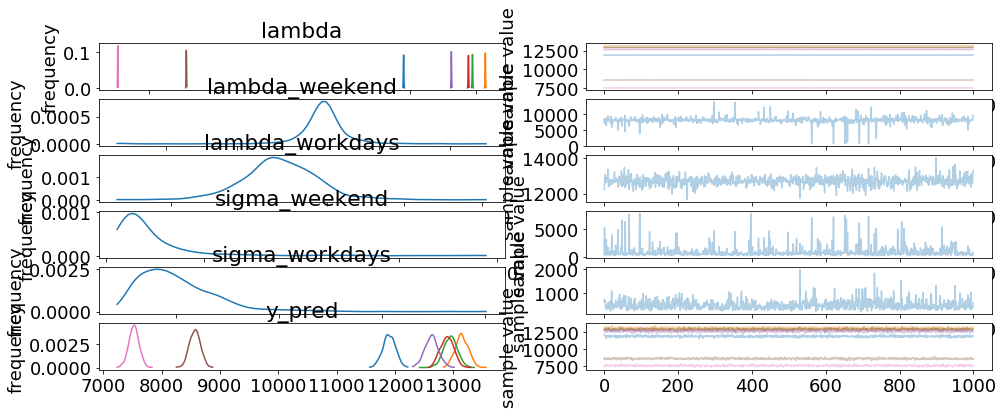

In [101]:
fit.plot()

In [100]:
fit.extract()['lambda'].mean(axis=0)

array([11899.79869835, 13149.78110244, 12953.3567847 , 12891.14438672,
       12630.40868165,  8575.35731746,  7526.05349873])

In [102]:
fit.extract()['y_pred'].mean(axis=0)

array([11900.466, 13145.767, 12950.815, 12892.302, 12626.222,  8572.909,
        7527.666])

In [85]:
def fit_stan_model_sliding_windows(num_windows, stan_model):
    prediction_errors = []
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        fit = stan_model.sampling(seed=COMMON_SEED, data=dict(
            x_train=data['x_train'],
            x_test=data['x_test'],
            y=data['y_train'],
            T=7,
            N=len(data['x_train'])), iter=500)
        check_convergence(fit)
        y_pred_avg = fit.extract()['lambda'].mean()
#         print(data)
#         y_pred = historical_average(data['x_train'], data['y_train'])[data['x_test'] - 1].round()
#         prediction_errors.append(y_pred - data['y_test'])
#         print(y_pred)
#         print(data['y_test'])
#     return np.concatenate(prediction_errors)

fit_stan_model_sliding_windows(1, model_hier_poisson)


Inference for Stan model: anon_model_7c6efaa7f8e043fff3dc6993bdcca6cb.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]        1.2e4    0.13   4.04  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4   1000    1.0
lambda[1]        1.3e4    0.14    4.4  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4   1000    1.0
lambda[2]        1.3e4    0.13   4.24  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4   1000    1.0
lambda[3]        1.3e4    0.14   4.28  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4   1000    1.0
lambda[4]        1.3e4    0.13   4.21  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4   1000    1.0
lambda[5]       8576.7    0.11    3.4 8570.3 8574.4 8576.6 8578.9 8583.6   1000    1.0
lambda[6]       7526.9     0.1   3.14 7521.0 7524.7 7527.0 7529.0 7533.0   1000    1.0
lambda_weekend 1.1e139 1.1e1392.4e140 3711.4 4.6e11 3.5e18 3.6e39 8.2e98    504    1.0
lambda_workdays  1.3e4   42.58 

# Predictive Performance Assessment
RMSE, MAE, widht of 95% C.I.
Cross-Validation?

# Discussion of Potential Improvements
Discussion of problems and potential improvements:
* Use contextual information, which is known to account for trends in the data.
* Compare to some classic baseline models for time series prediction, e.g. Seasonal ARIMA with exogenous variables.
* More sensitivity analysis for choice of prior. 

# Conclusion
In particular, emphasize one main conclusion.